In [8]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("in colab?", IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive/")
    os.chdir('/content/gdrive/MyDrive/Denoise/xjobb')
    !pwd # print current path
    # Install non-standard colab dependencies.
    !pip install torchinfo
    !pip install torchmetrics
    !pip install torchxrayvision

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.models as models
import time
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import datetime
import pickle
import os
import torchxrayvision as xrv

# after !pip install (in case of colab)
from torchmetrics.image import StructuralSimilarityIndexMeasure
import torchinfo

from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

torch.cuda.empty_cache()

# Select device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()

print("Device: {}".format(device))

# util functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


from utils.cxr_processing import *
from utils.diagnosis import *
from utils.cxr_dataset import *
from utils.cxr_display import *

from nih_dataset import *

in colab? False
Device: cuda


In [ ]:
DATA_PATH = "../data/NIH/"

nih_train_val = NIH_CxrLblDataset(DATA_PATH, img_root_override=DATA_PATH)
nih_test = NIH_CxrLblDataset(DATA_PATH, img_root_override=DATA_PATH, test=True)

TRAIN_DATA = 4 # FOR TESTING! 
#TRAIN_DATA = int(len(nih_train_val) * 0.8)

nih_train, nih_val = split_dataset_at(nih_train_val, TRAIN_DATA, cutoff=TRAIN_DATA * 2) # VAL_DATA will never be larger than TRAIN_DATA for testing

BATCH_SIZE = 2

train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)


NOISE_STRENGTH = 0.2
MIN_SIGNAL = 0.01

NOISE_MOD = NoiseModule(NOISE_STRENGTH, MIN_SIGNAL).to(device)

print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")

train/val/test: 4/4/4


In [10]:
# Load diagnosis model for evaluation
diagnosis_model = xrv.models.DenseNet(weights="densenet121-res224-nih")
diagnosis_model.to(device)
diagnosis_model.eval()

diagnosis_val_tester = NihTester(nih_val)
diagnosis_test_tester = NihTester(nih_test)

In [11]:
from utils.unet import UNet
model = UNet(s=2, k=8).to(device)
torchinfo.summary(model, (BATCH_SIZE,1,1024,1024))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [2, 1, 1024, 1024]        --
├─ModuleList: 1-1                             --                        --
│    └─EncoderStep: 2-1                       [2, 8, 512, 512]          --
│    │    └─DoubleConv: 3-1                   [2, 8, 1024, 1024]        696
│    │    └─MaxPool2d: 3-2                    [2, 8, 512, 512]          --
│    └─EncoderStep: 2-2                       [2, 16, 256, 256]         --
│    │    └─DoubleConv: 3-3                   [2, 16, 512, 512]         3,552
│    │    └─MaxPool2d: 3-4                    [2, 16, 256, 256]         --
├─DoubleConv: 1-2                             [2, 32, 256, 256]         --
│    └─Sequential: 2-3                        [2, 32, 256, 256]         --
│    │    └─Conv2d: 3-5                       [2, 32, 256, 256]         4,640
│    │    └─BatchNorm2d: 3-6                  [2, 32, 256, 256]         64
│    │    └─R

auc baselines: noisy=0.5093, clean=0.7539


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


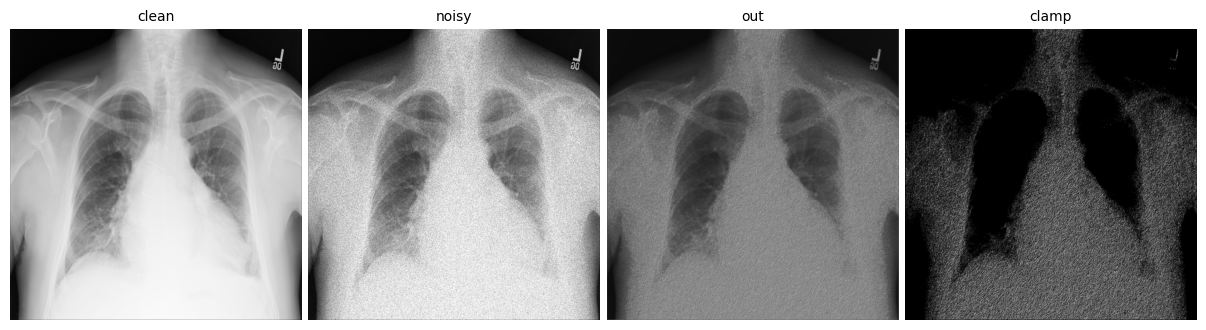

100%|██████████| 2/2 [00:00<00:00, 11.94it/s]


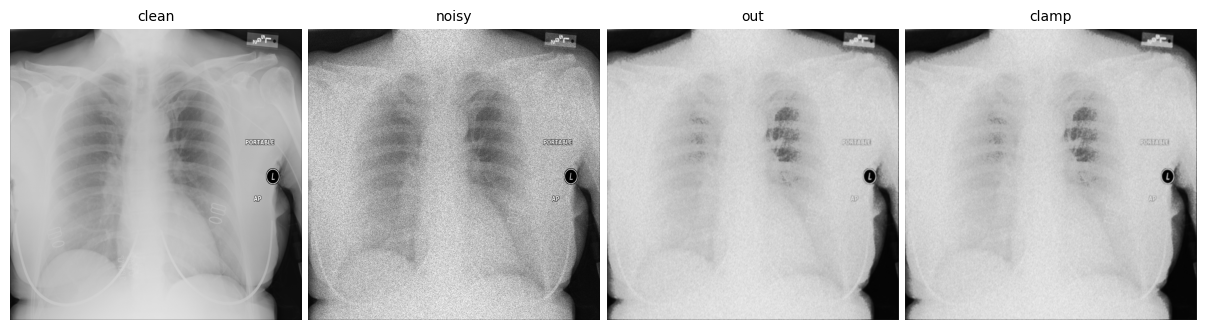

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



Epoch 1/10, Train Loss: 0.6228, Val Loss: 0.2010, Val SSIM: 0.5654, avg AUC: 0.6667 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


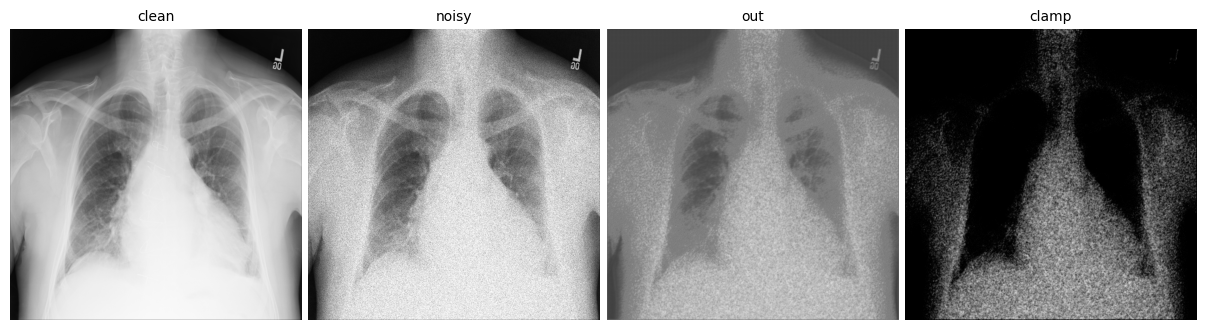

100%|██████████| 2/2 [00:00<00:00, 11.50it/s]


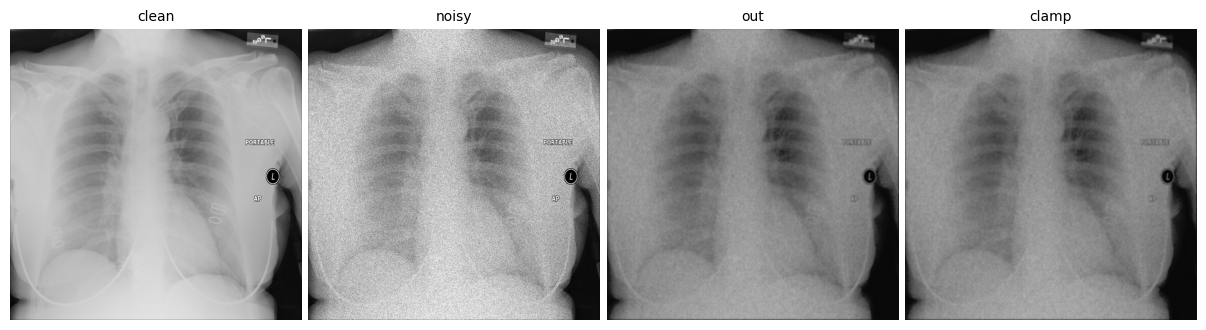

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



Epoch 2/10, Train Loss: 0.3162, Val Loss: 0.0792, Val SSIM: 0.2215, avg AUC: 0.0000 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


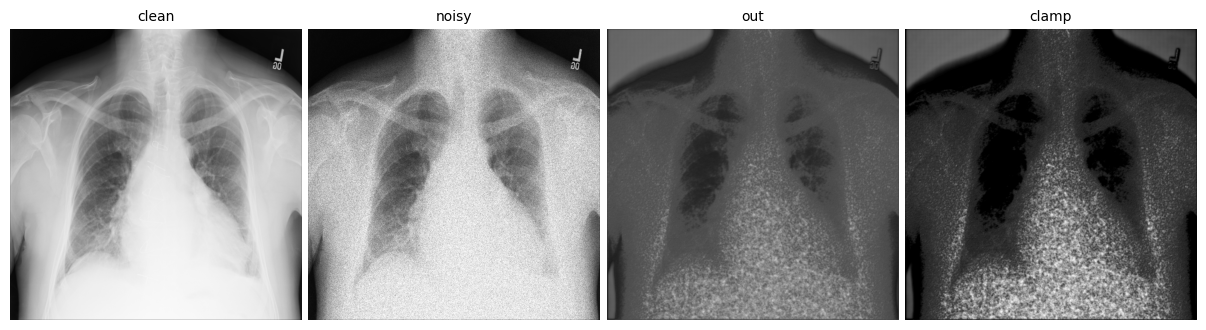

100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


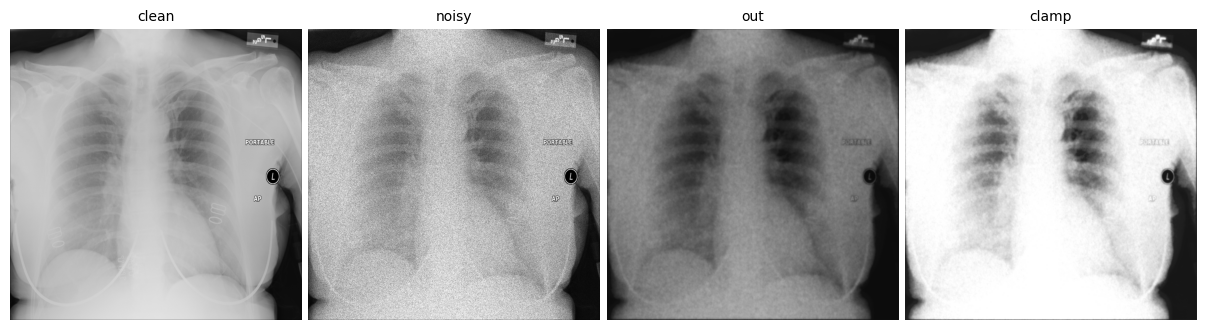

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



Epoch 3/10, Train Loss: 0.1855, Val Loss: 0.3308, Val SSIM: 0.4489, avg AUC: 0.8333 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


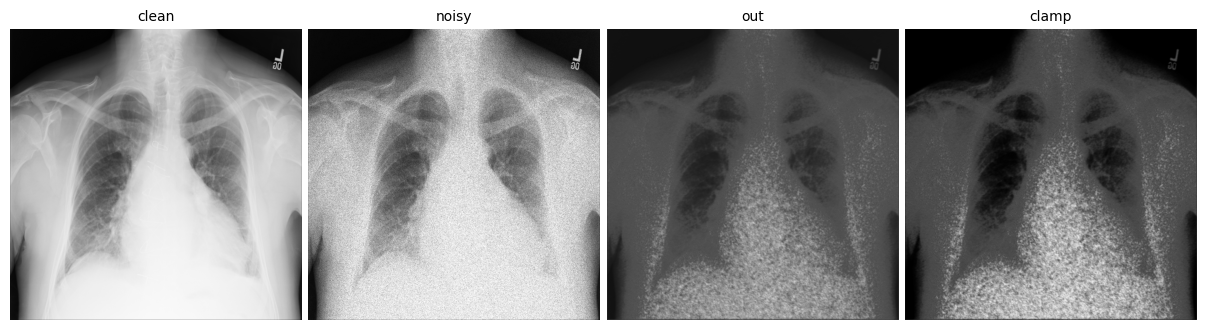

100%|██████████| 2/2 [00:00<00:00, 11.82it/s]


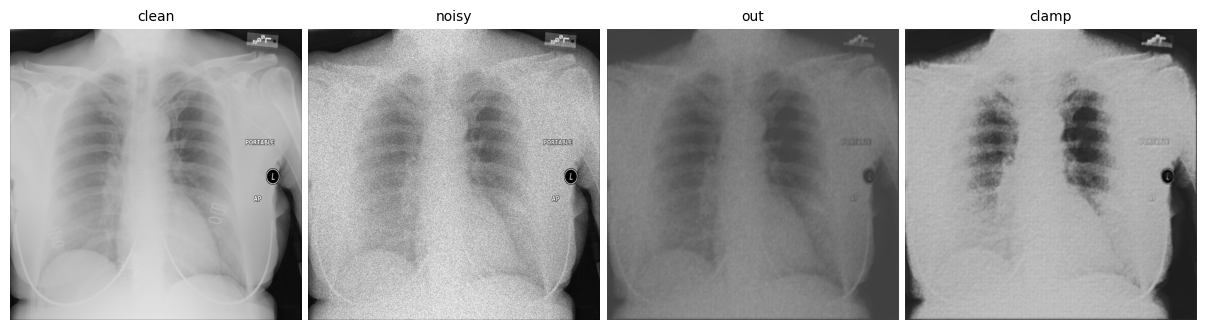

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



Epoch 4/10, Train Loss: 0.1103, Val Loss: 0.6763, Val SSIM: 0.1070, avg AUC: 0.1667 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


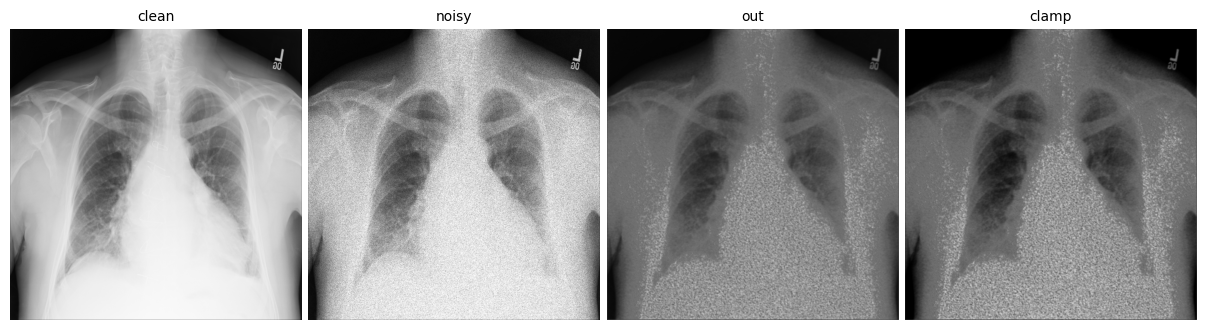

100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


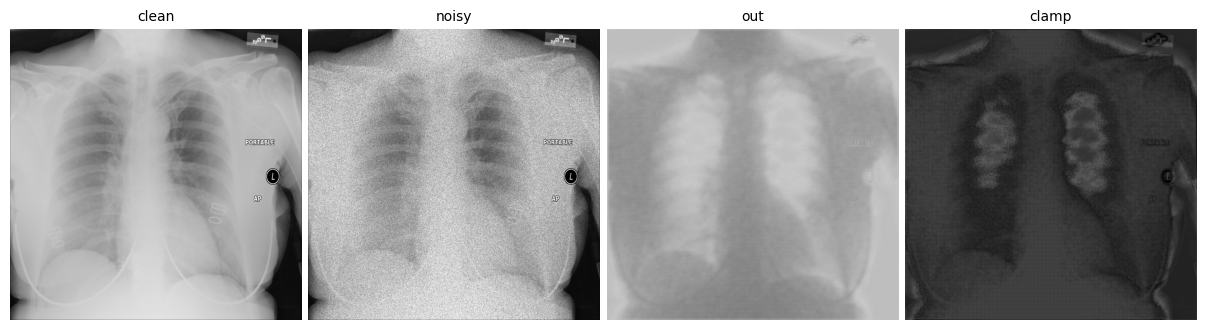

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



Epoch 5/10, Train Loss: 0.0576, Val Loss: 1.9777, Val SSIM: 0.1424, avg AUC: 0.3333 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


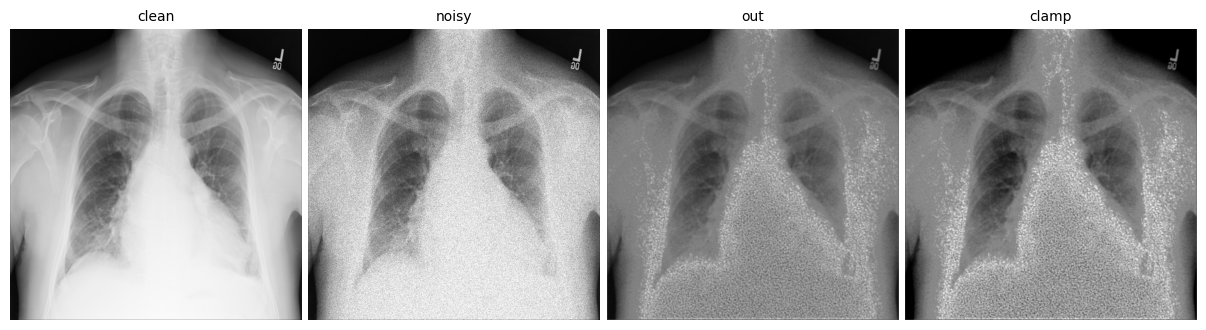

100%|██████████| 2/2 [00:00<00:00, 10.81it/s]


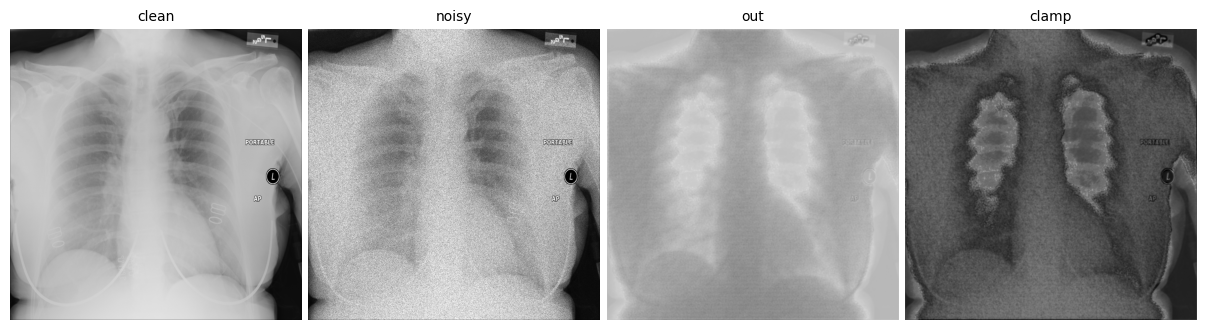

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



Epoch 6/10, Train Loss: 0.0288, Val Loss: 1.3022, Val SSIM: 0.2115, avg AUC: 0.3333 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


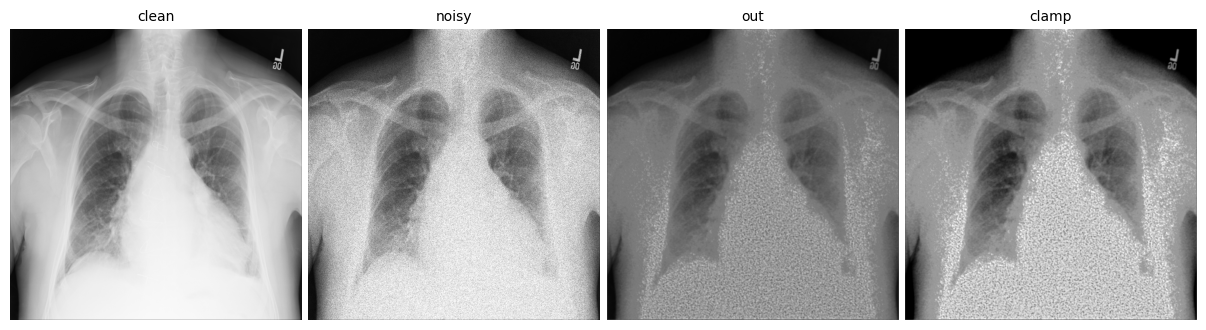

100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


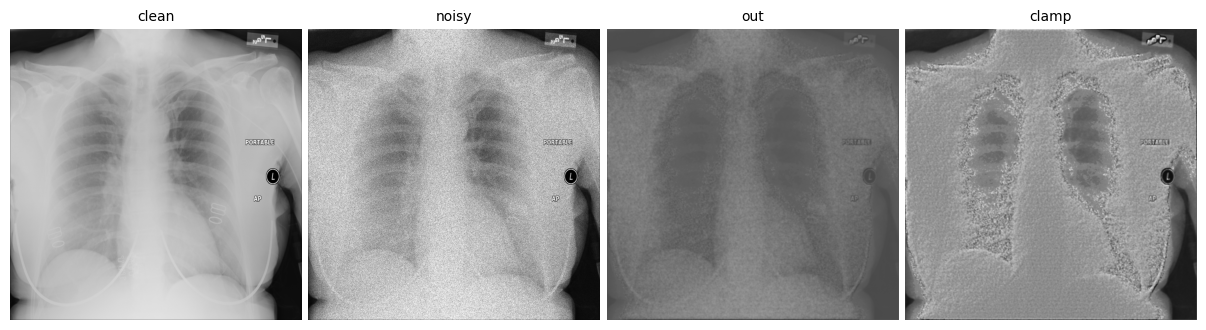

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



Epoch 7/10, Train Loss: 0.0157, Val Loss: 0.6567, Val SSIM: 0.2762, avg AUC: 0.3333 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


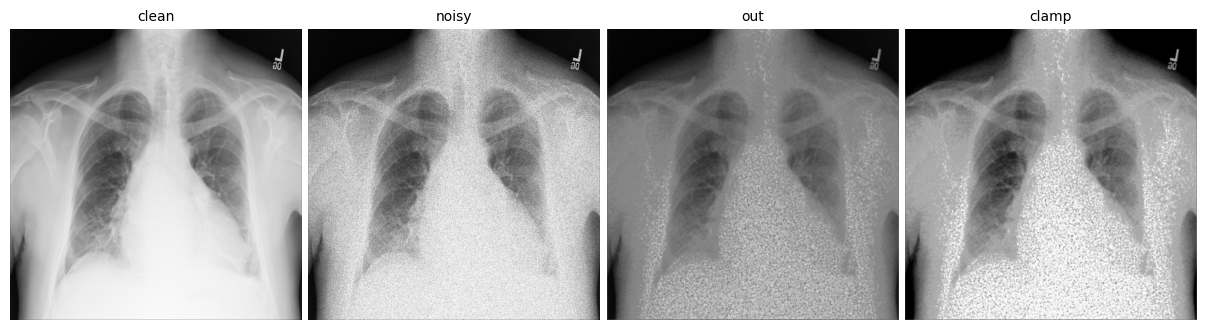

100%|██████████| 2/2 [00:00<00:00, 11.05it/s]


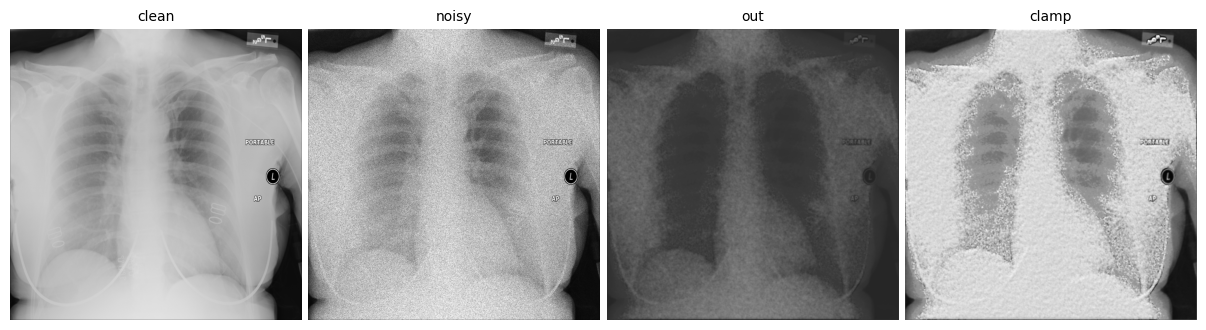

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



Epoch 8/10, Train Loss: 0.0127, Val Loss: 1.4444, Val SSIM: 0.3171, avg AUC: 0.0000 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


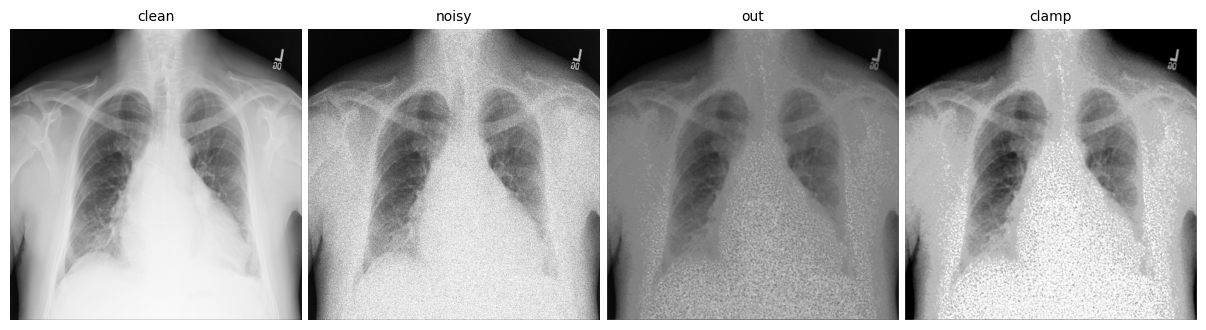

100%|██████████| 2/2 [00:00<00:00, 12.11it/s]


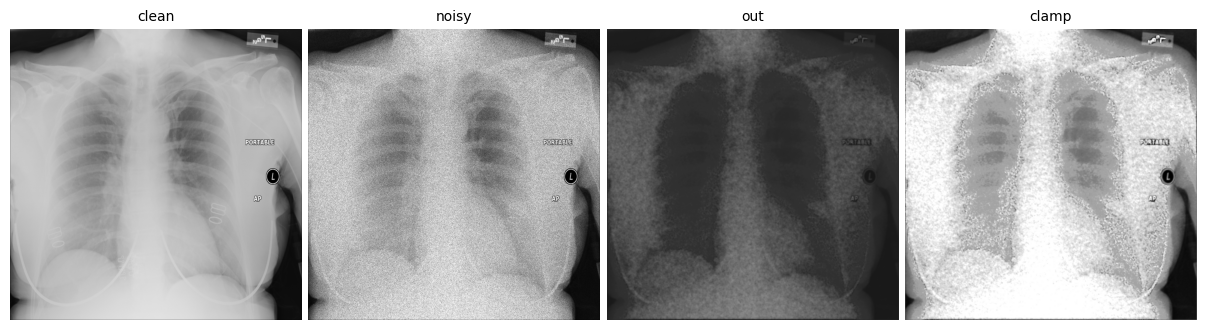

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



Epoch 9/10, Train Loss: 0.0167, Val Loss: 1.3591, Val SSIM: 0.5506, avg AUC: 0.3333 (noisy=0.5093, clean=0.7539)


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


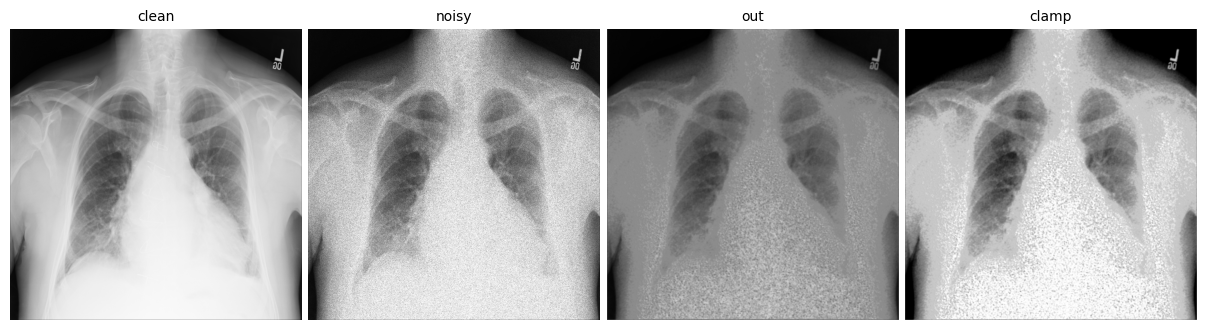

100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


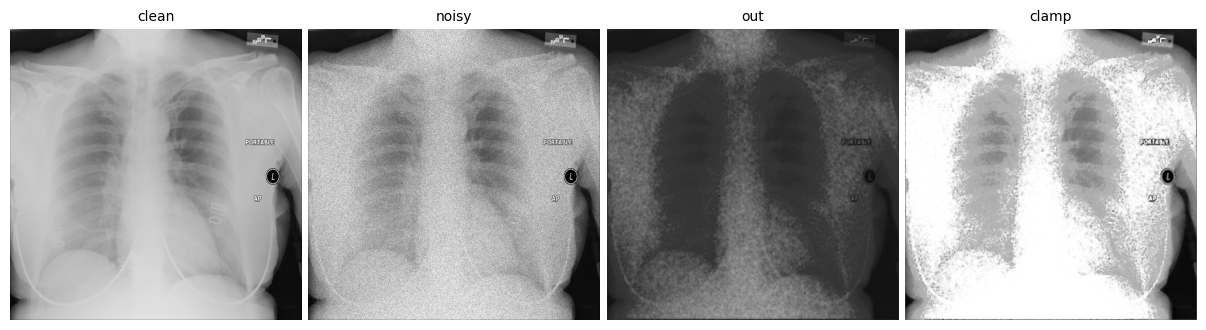

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Epoch 10/10, Train Loss: 0.0226, Val Loss: 0.7851, Val SSIM: 0.6746, avg AUC: 0.6667 (noisy=0.5093, clean=0.7539)


In [ ]:
NUM_EPOCHS = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

train_loss_hist, val_loss_hist, train_ssim_hist, val_ssim_hist, val_diag_auc_hist, val_epoch_idxs = [], [], [], [], [], []
start_time = last_epoch_time = time.time()


# --- auc baselines ---

# diagnosis_val_tester.gather_outputs_labels_module(NOISE_MOD)
# noisy_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

# diagnosis_val_tester.gather_outputs_labels_module(nn.Identity())
# clean_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

clean_auc = 0.7539 # noise = 0.2
noisy_auc = 0.5093 # noise = 0.2

print(f"auc baselines: noisy={noisy_auc:.4f}, clean={clean_auc:.4f}")

# --- Training loop ---
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_ssim = 0.0

    for i, (clean, _lbls) in enumerate(tqdm(train_dl)):
        clean = clean.to(device)
        noisy = NOISE_MOD(clean).to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * noisy.size(0)
        # train_ssim += ssim(clean, outputs).item() * noisy.size(0) # very slow

    train_loss /= len(train_dl.dataset)
    train_ssim /= len(train_dl.dataset)
    train_loss_hist.append(train_loss)
    train_ssim_hist.append(train_loss)

    plot_cxr_images([clean[0], noisy[0], outputs[0], outputs[0].clamp(0,1)], ["clean", "noisy", "out", "clamp"]) # first img of last batch

    # --- Validation ---
    if True:

        model.eval()
        val_loss = 0.0
        val_ssim = 0.0
        with torch.no_grad():
            model.eval()
            for i, (clean, _lbls) in enumerate(tqdm(val_dl)):
                clean = clean.to(device)
                noisy = NOISE_MOD(clean).to(device)
        
                outputs = model(noisy)
                loss = criterion(outputs, clean)

                val_loss += loss.item() * noisy.size(0)
                val_ssim += ssim(clean, outputs.clamp(0,1)).item() * noisy.size(0) 

            val_loss /= len(val_dl.dataset)
            val_ssim /= len(val_dl.dataset)

            val_loss_hist.append(val_loss)
            val_ssim_hist.append(val_ssim)
            

            plot_cxr_images([clean[0], noisy[0], outputs[0], outputs[0].clamp(0,1)], ["clean", "noisy", "out", "clamp"]) # first img of last batch

            noise_denoise_module = nn.Sequential(NOISE_MOD, model)
            diagnosis_val_tester.gather_outputs_labels_module(noise_denoise_module)
            avg_auc = diagnosis_val_tester.avg_diagnosis_auc()

            val_diag_auc_hist.append(avg_auc)

            val_epoch_idxs.append(epoch)
            
            print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val SSIM: {val_ssim:.4f}, "
                  f"avg AUC: {avg_auc:.4f} (noisy={noisy_auc:.4f}, clean={clean_auc:.4f})"
                  )
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
            }, f"models/checkpoints/checkpoint_epoch_{epoch}.pth")




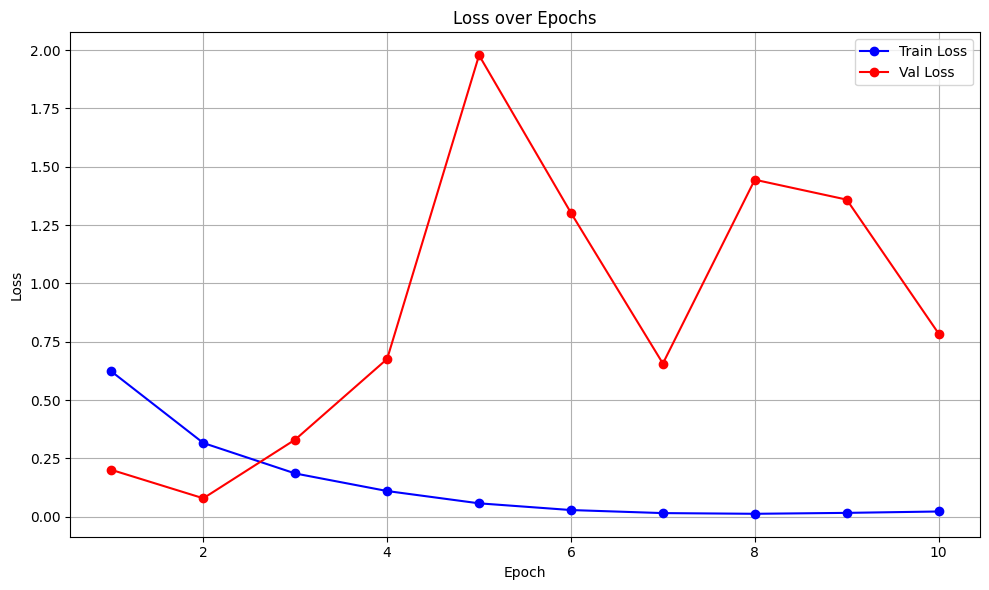

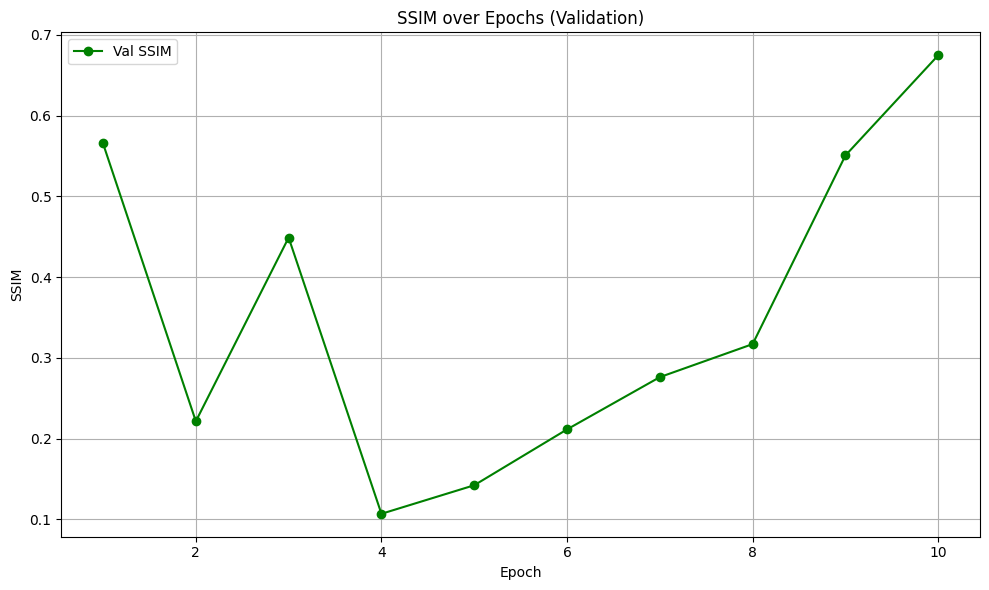

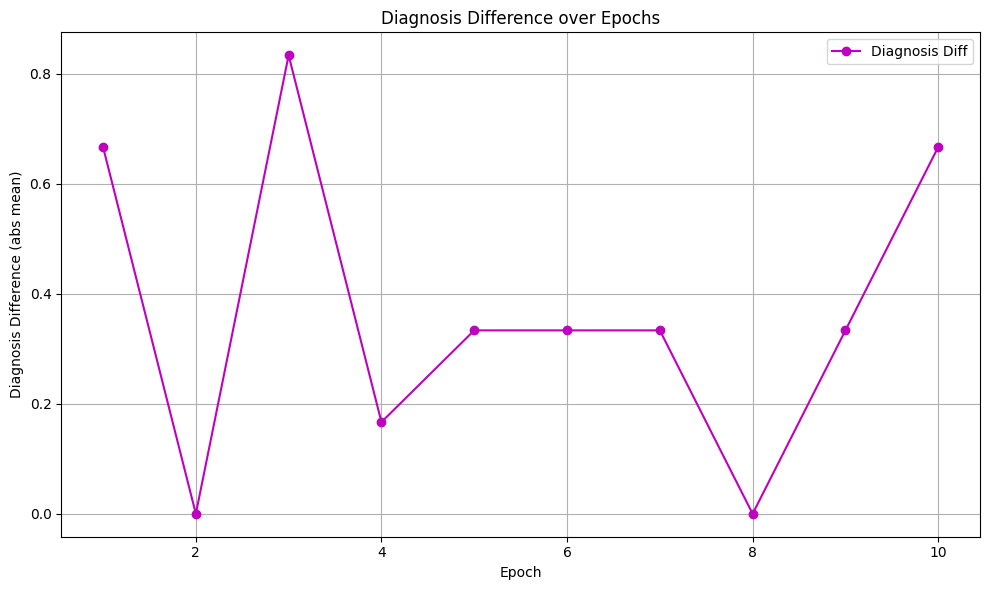

In [13]:
# --- Plotting ---
epochs = list(range(1, NUM_EPOCHS + 1))
val_epochs = [i + 1 for i in val_epoch_idxs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_hist, "b-o", label="Train Loss")
plt.plot(val_epochs, val_loss_hist, "r-o", label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_epochs, val_ssim_hist, "g-o", label="Val SSIM")
plt.title("SSIM over Epochs (Validation)")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_epochs, val_diag_auc_hist, "m-o", label="Diagnosis Diff")
plt.title("Diagnosis Difference over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Diagnosis Difference (abs mean)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


In [14]:
# --- Final Test Evaluation ---
model.eval()
test_loss = 0.0
test_ssim_score = 0.0

with torch.no_grad():
    for (clean, _lbls) in tqdm(test_dl, desc="Final Test Evaluation"):
        clean = clean.to(device)
        noisy = NOISE_MOD(clean).to(device)

        outputs = model(noisy)
        test_loss += criterion(outputs, clean).item() * noisy.size(0)
        test_ssim_score += ssim(outputs, clean).item() * noisy.size(0)

test_loss /= len(test_dl.dataset)
test_ssim_score /= len(test_dl.dataset)

noise_denoise_module = nn.Sequential(NOISE_MOD, model)
diagnosis_val_tester.gather_outputs_labels_module(noise_denoise_module)
test_avg_auc = diagnosis_val_tester.avg_diagnosis_auc()

print(f"""
--- Final Test Performance ---
Test Loss:         {test_loss:.4f}
Test SSIM:         {test_ssim_score:.4f}
Diagnosis Avg AUC:    {test_avg_auc:.4f}
""")

random_three_letters = "".join(np.random.choice(list("abcdefghijklmnopqrstuvwxyz"), 3))
torch.save(model.state_dict(), f"models/{model.name()}_{random_three_letters}.pth")

import json
from datetime import datetime

model_metadata = {
    "model_name": model.name(),
    "model_name_random_suffix": random_three_letters,
    "model_file_name": f"{model.name()}_{random_three_letters}.pth",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "architecture": "UNet",
    "s": model.s,
    "k": model.k,
    "num_parameters": sum(p.numel() for p in model.parameters()),
    "num_epochs": NUM_EPOCHS,
    "num_train_images": len(train_dl.dataset),
    "val_loss": val_loss_hist[-1] if val_loss_hist else None,
    "val_ssim": val_ssim_hist[-1] if val_ssim_hist else None,
    "val_diag_diff": val_diag_auc_hist[-1] if val_diag_auc_hist else None,
    "test_loss": test_loss,
    "test_ssim": test_ssim_score,
    "test_diag_avg_auc": test_avg_auc
}

with open(f"models/{model.name()}_{random_three_letters}_meta.json", "w") as f:
    json.dump(model_metadata, f, indent=4)

torch.save({
    "model_state": model.state_dict(),
    "metadata": model_metadata
}, f"models/{model.name()}_{random_three_letters}_bundle.pth")

print(f"!saved model: '{model.name()}_{random_three_letters}'!")

Gathering outputs/labels: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]




--- Final Test Performance ---
Test Loss:         1.0386
Test SSIM:         0.3987
Diagnosis Avg AUC:    0.6667

!saved model: 'unet-s2k8_zke'!
